#  Real Estate Valuation

This is a real estate multivariate regression problem. Well be going through the "checklist" defined in Appendix B in the book [Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291). I'll be expliclity answering all the questions and going through each step to improve my learning, even though a lot of the questions don't make sense or apply super well to just doing this process for learning.

I'll preface answers with

> Pretend

if I'm making up an answer for this example.

In [79]:
# allows our matplotlib graphs to be display inline
%matplotlib inline

In [80]:
SEED = 42

In [212]:
import urllib.request # for fetching our raw data from the web
import pandas as pd # for easily manipulating our data
from pandas.plotting import scatter_matrix # for comparing all independent and dependent variables against each other
import seaborn as sns # for pretty graphs
import matplotlib.pyplot as plt # to stop graphs from plotting over one another
from scipy.stats import shapiro # for testing for normality
import statsmodels.api as sm # for making QQ plots
from IPython.display import Image, display # for display a local image, as the markdown way does not work with sibling folders
from sklearn.preprocessing import RobustScaler # for scaling our numerical independent variables
from sklearn.model_selection import train_test_split # for train test split
from sklearn.linear_model import LinearRegression # for linear regression
from sklearn.ensemble import RandomForestRegressor # for random forest regressor
from sklearn.metrics import mean_absolute_error # for MAE
from keras.models import Sequential # for neural network
from keras.wrappers.scikit_learn import KerasRegressor # for keras regressor
from keras.layers import Dense # for layers
from sklearn.model_selection import cross_val_score, KFold # for crossvalidation

# For graphically geographically
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

## Part A: Frame the Problem and Look at the Big Picture
 
1. Define the objective in business terms.

(Pretend) We want to predict real estate valuations in New Taipei City, Taiwan to increase our ability to effectively bid on lots.

2. How will your solution be used?

(Pretend) Our solution will be used to ensure we our bids are accurate, maximizing profit.

3. What are the current solutions/workarounds (if any)?

(Pretend) None.

4. How should you frame this problem (supervised/unsupervised, online/offline, etc.)?

Supervised. The data sets have house_price_of_unit_area attached. 

Offline. All the data that existed has been already gathered and all the training will be done at once.

5. How should performance be measured?

When deciding which performance metric to use, we have a lot of options to pick from.

1. Mean Squared Error (MSE)
2. Root Mean Squared Error (RMSE)
3. Mean Absolute Error (MAE)
4. R Squared (R²)
5. Adjusted R Squared $(R²)$
6. Mean Square Percentage Error (MSPE)
7. Mean Absolute Percentage Error (MAPE)
8. Root Mean Squared Logarithmic Error (RMSLE)

I have decided that we'll use MAE:

$\text{MAE} = \frac{1}{N}\sum_{i=1}^{N}|{y_{i}-\hat{y}_{i}}|$

I've decided to use MAE, as I believe we'll have some outliers in our data set. 

I used this [article](https://towardsdatascience.com/how-to-select-the-right-evaluation-metric-for-machine-learning-models-part-1-regrression-metrics-3606e25beae0) to help decide what would be a proper performance measurement.

6. Is the performance measure aligned with the business objective?

Yes, since we're predicting the value of houses, we'll be able to look at our error function's output and compare different models against each other, knowing we can treat a 10 MSE as exactly twice as bad as a 5 MSE. This works very well with the financial aspect of what we're modeling here.

7. What would be the minimum performance needed to reach the business objective?

(Pretend) We want to be within 25% of the valuation of a house, so we can see if it is worth gathering more data to try and further refine our model.

8. What are comparable problems? Can you reuse experience or tools?

(Pretend) Our company has had no comparable problems, nor can we reuse experience or tools.

9. Is human expertise available?

(Pretend) No.

10. How would you solve the problem manually?

I'd attempt to solve this problem manually by looking at all the houses that sold for the most amount and the houses that sold for the least amount and look for patterns that may elude to what would effect each house's price.

11. List the assumptions you (or others) have made so far.

While I have no assumptions regarding the dataset as a whole, I'll be listing column specific assumptions in section C.

12. Verify assumptions if possible.

Will do in Part C.

## Part B: Get the Data

_Note: automate as much as possible so you can easily get fresh data._

1. List the data you need and how much you need.

We'll just use the dataset we found before starting this project. If we were to answer this without acknowledging the dataset we've already found, we'd want a many rows as possible where columns would be potential variables that contributed to valuation of a house.

2. Find and document where you can get that data.

We can get this data at this [location](https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set).

3. Check how much space it will take.

32 KB.

4. Check legal obligations, and get authorization if necessary.

UCI's data is free.

5. Get access authorizations.

Not needed.

6. Create a workspace (with enough storage space).

Done using [Cookiecutter Data Science](https://drivendata.github.io/cookiecutter-data-science/).

7. Get the data.

Done below.

8. Convert the data to a format you can easily manipulate (without changing the data itself).

Not needed.

9. Ensure sensitive information is deleted or protected (e.g., anonymized).

Not needed.

10. Check the size and type of data (time series, sample, geographical, etc.).

I'm not sure what to call the kind of data we're working with. Each row represents the action of selling a house, how much it sold for and a few other potentially related measurements.

11. Sample a test set, put it aside, and never look at it (no data snooping!).

We'll do this later, as we have cleaning to perform in the next section.

In [82]:
# We we should store our raw hosuing data
STORE_RAW_HOUSING_DATA_DESTINATION_PATH = "../data/raw/real_estate_valuation_data_set.xlsx"

In [83]:
def fetch_raw_housing_data(STORE_RAW_HOUSING_DATA_DESTINATION_PATH: str = STORE_RAW_HOUSING_DATA_DESTINATION_PATH):
    """Fetches our raw housing data.
    
    """
    # We we can fetch out raw data from
    RAW_DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00477/Real%20estate%20valuation%20data%20set.xlsx"
    
    urllib.request.urlretrieve(RAW_DATA_URL, STORE_RAW_HOUSING_DATA_DESTINATION_PATH)
    
fetch_raw_housing_data()

In [84]:
def load_raw_hosuing_data(STORE_RAW_HOUSING_DATA_DESTINATION_PATH: str = STORE_RAW_HOUSING_DATA_DESTINATION_PATH) -> pd.DataFrame:
    """Loads the raw housing data we've previously fetched
    
    """
    
    names = ["No", "transaction_date", "house_age", "distance_to_the_nearest_MRT_station", "number_of_convenience_stores", "latitude", "longitude", "house_price_of_unit_area"]
        
    # creating our base data frame
    # I know there needs to be some cleaning on the `transaction_date` independent variable.
    # We could have done that here using the parse_dates keyword flag and a parser keyword flag to a lambda or function, but we'll handle that later
    df = pd.read_excel(STORE_RAW_HOUSING_DATA_DESTINATION_PATH, names=names, index_col="No")
    

    return df

df = load_raw_hosuing_data()

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 1 to 414
Data columns (total 7 columns):
transaction_date                       414 non-null float64
house_age                              414 non-null float64
distance_to_the_nearest_MRT_station    414 non-null float64
number_of_convenience_stores           414 non-null int64
latitude                               414 non-null float64
longitude                              414 non-null float64
house_price_of_unit_area               414 non-null float64
dtypes: float64(6), int64(1)
memory usage: 25.9 KB


In [86]:
df.describe()

,transaction_date,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [87]:
df.head()

,transaction_date,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area
No,,,,,,,
1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


We have successfully gathered the data we need.

## Part C: Explore the Data

_Note: try to get insights from a field expert for these steps._

1. Create a copy of the data for exploration (sampling it down to a manageable size if necessary).

The data is not big enough for me to consider this necessary. 

2. Create a Jupyter notebook to keep a record of your data exploration.

We'll be doing that in this notebook.

3. Study each attribute and its characteristics:

  - Name
  - Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
  - % of missing values
  - Noisiness and type of noise (stochastic, outliers, rounding errors, etc.)
  - Possibly useful for the task?
  - Type of distribution (Gaussian, uniform, logarithmic, etc.)
  
Will do on a column by column basis. Skipping noiseness analysis and type of distribution. I rolled "Possibly useful" into a new bullet I called "assumptions".

4. For supervised learning tasks, identify the target attribute(s).

The taret attribute is `house_price_of_unit_area`

5. Visualize the data.

We'll do this column by column and then a big scatter matrix.

6. Study the correlations between attributes.

We'll evaluate the correlations visually and by using Pearson's R.

7. Study how you would solve the problem manually.

I believe we went over this prior, but I would solve the problem manually by looking at the extremes of the data. I'd look at the most expensive houses and the least expensive houses and attempt to explain why those houses were cheaper or more expensive. Just to be clear, I would not want to look at outliers specifically but rather the non-outliers on each end of the valuation.

8. Identify the promising transformations you may want to apply.

I plan to clean `transaction_date`, so its easier to query. I'm not exactly sure what format I'll use, but whatever Pandas suggests.

9. Identify extra data that would be useful (go back to “Get the Data”).

It would be useful to get:

- number of bathrooms
- number of bedrooms
- is there an attic
- is there a basement
- is there a garage
- amount of land
- crime in the area
- quality of education in the area

Map of the location our data is sampled from.

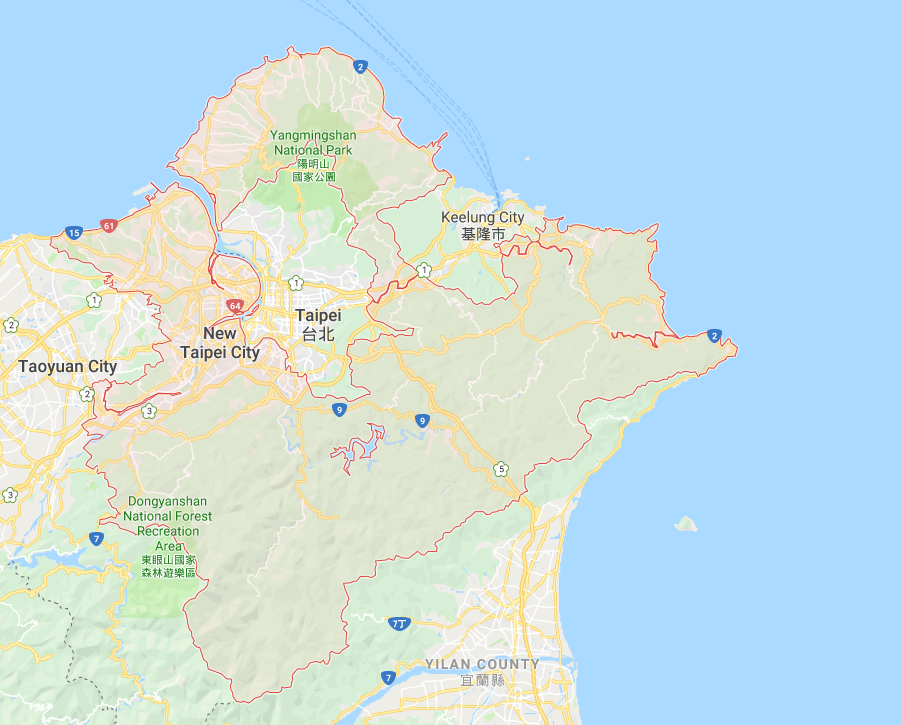

In [88]:
display(Image(filename="../references/city_map.png"))

## All Columns

First we'll do a very quick high level overview of all the columns together, before diving into each column individually. In a large data set, we'd use this section to help decide which columns to look at individually. Since this dataset is rather small, I'll take the oppurtunity to explore all columns

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 1 to 414
Data columns (total 8 columns):
transaction_date                       414 non-null float64
house_age                              414 non-null float64
distance_to_the_nearest_MRT_station    414 non-null float64
number_of_convenience_stores           414 non-null int64
latitude                               414 non-null float64
longitude                              414 non-null float64
house_price_of_unit_area               414 non-null float64
geometry                               414 non-null object
dtypes: float64(6), int64(1), object(1)
memory usage: 29.1+ KB


In [207]:
df.describe()

,transaction_date,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [208]:
df.head()

,transaction_date,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area,geometry
No,,,,,,,,
1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9,POINT (121.54024 24.98298)
2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2,POINT (121.53951 24.98034)
3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3,POINT (121.54391 24.98746)
4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8,POINT (121.54391 24.98746)
5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1,POINT (121.54245 24.97937)


## Scatter Matrix

We'll create single graphic of all columns against all other columns.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1435c7128>,
      dtype=object)

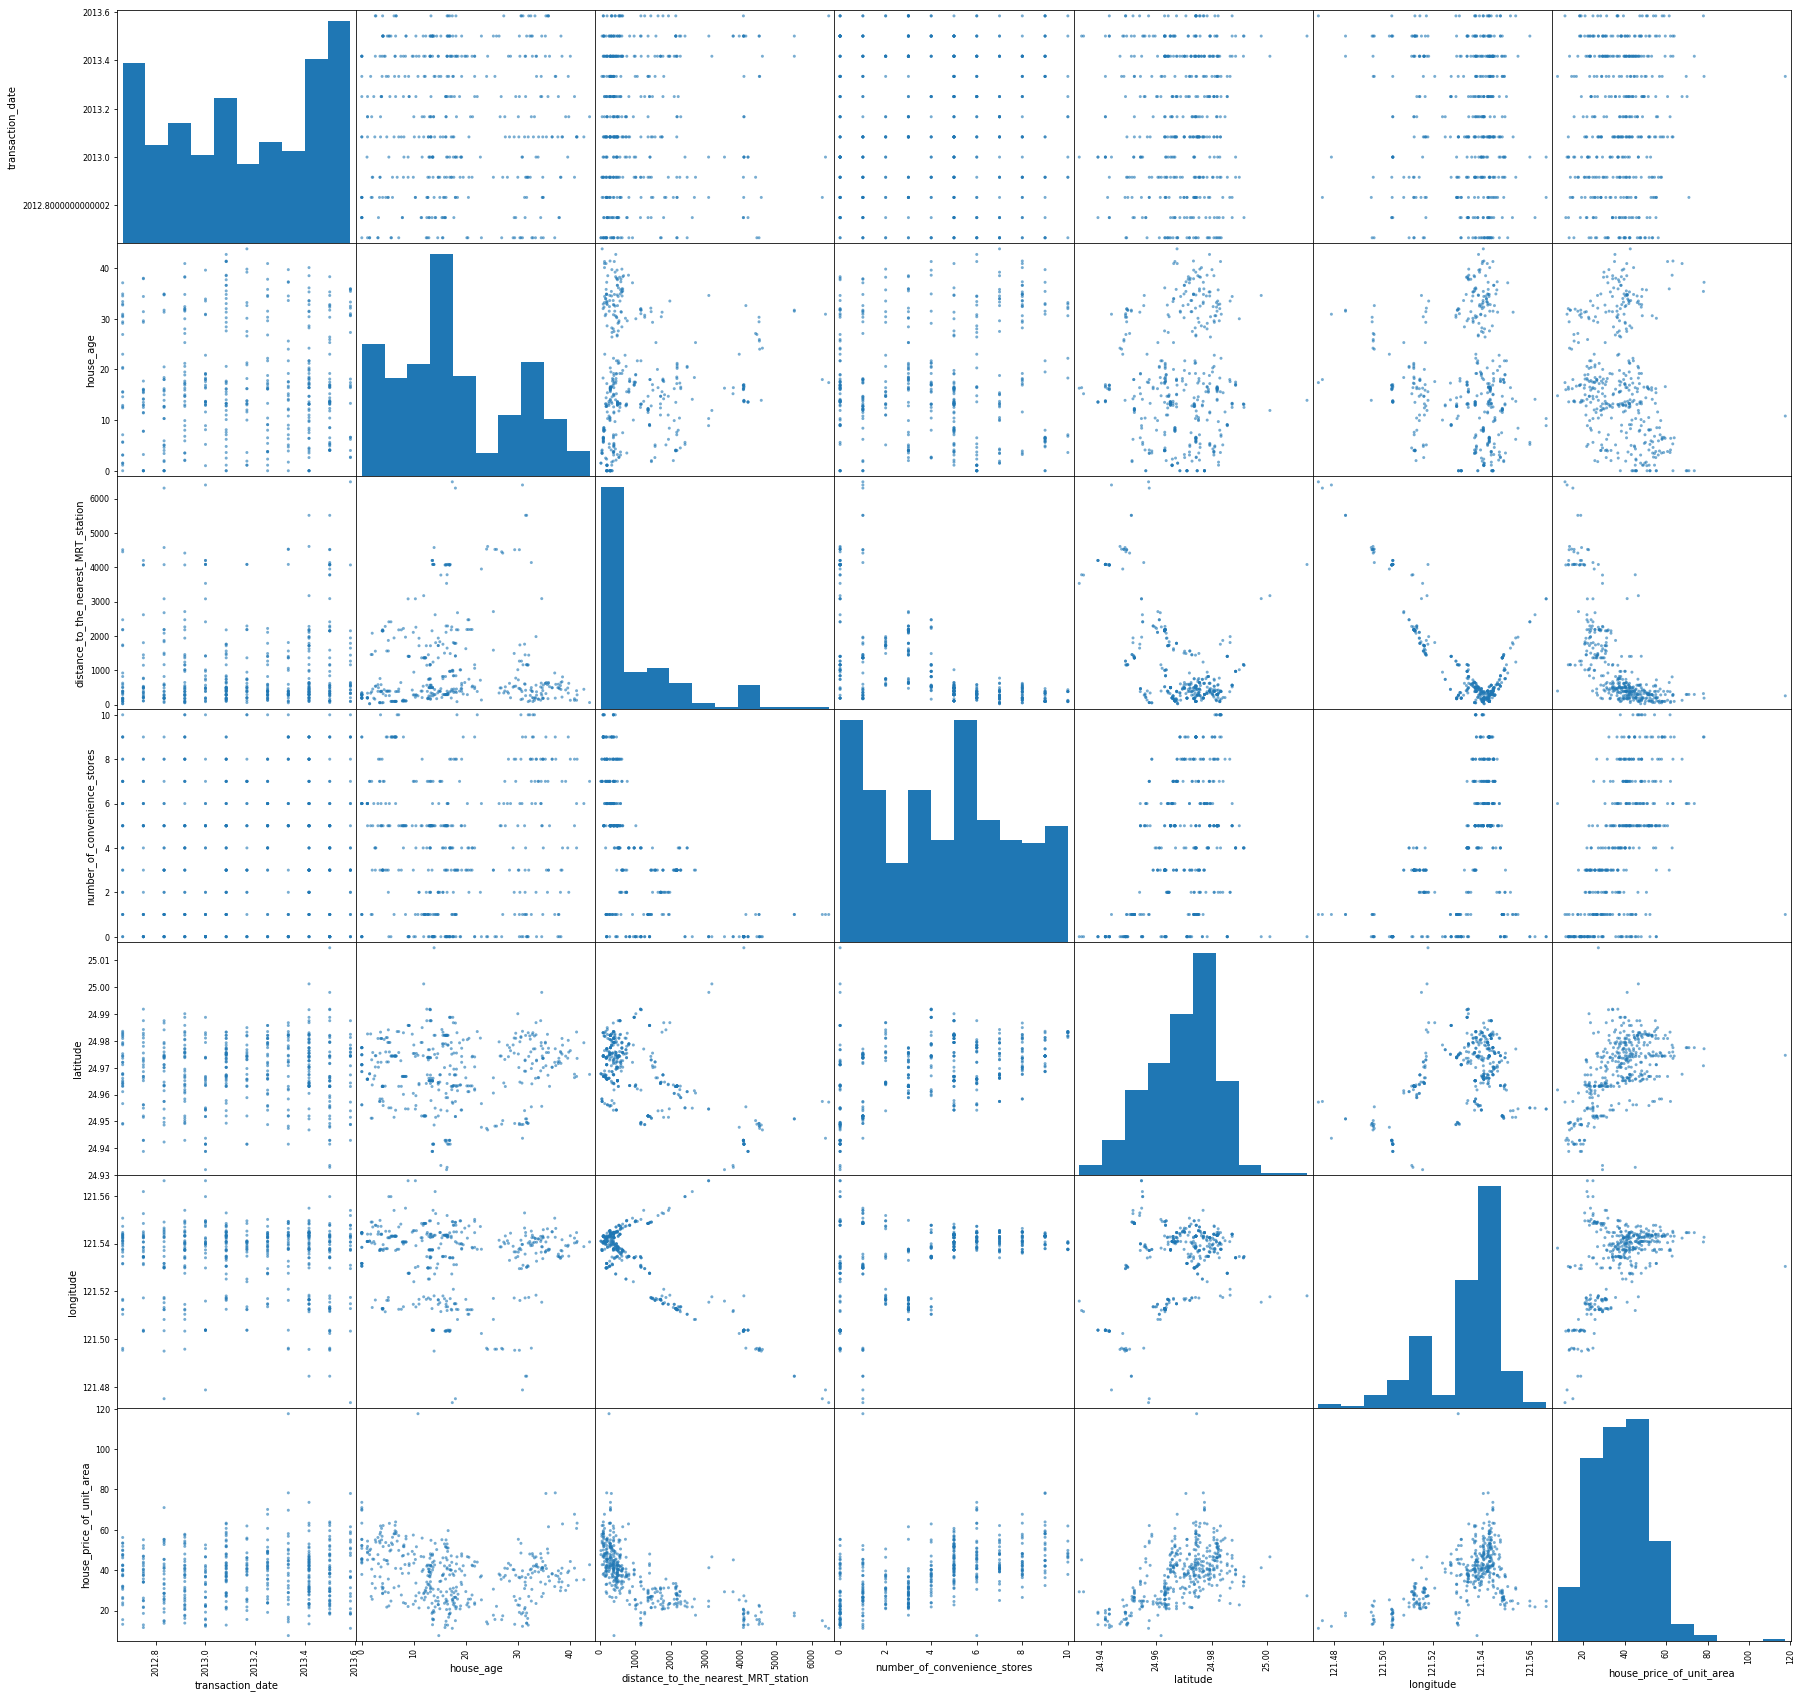

In [89]:
scatter_matrix(df, alpha=0.6, figsize=(30, 30), diagonal='hist')

I like to look at the scatter matrix when we don't have a lot of columns, just to look at the big picture in one big graph. This generally isn't the best way to check for correlation between two columns, as its a visual check and we already looked at each of the independent columns against the dependent column already. Instead we'll be using Pearson's R, also know as the standard correlation coefficient.

### Correlation Matrix

In [90]:
corr_matrix = df.corr()
corr_matrix["house_price_of_unit_area"].sort_values(ascending=False)

house_price_of_unit_area               1.000000
number_of_convenience_stores           0.571005
latitude                               0.546307
longitude                              0.523287
transaction_date                       0.087529
house_age                             -0.210567
distance_to_the_nearest_MRT_station   -0.673613
Name: house_price_of_unit_area, dtype: float64

The correlation coefficients range from $-1$ to $1$. Close to $1$ tells us there's a strong positive correlation, while close to $-1$ means there's a strong negative correlation, and close to $0$ means no correlation.

We see here that `number_of_convenience_stores`, `latitude` and `longitude` look to have a strong positive correlation, while I'd say `transaction-date` has no correlation.

`house_age` has a weak negative correlation and `distance_to_the_nearest_MRT_station` has a strong negative correlation. 

### Correlation Heatmap

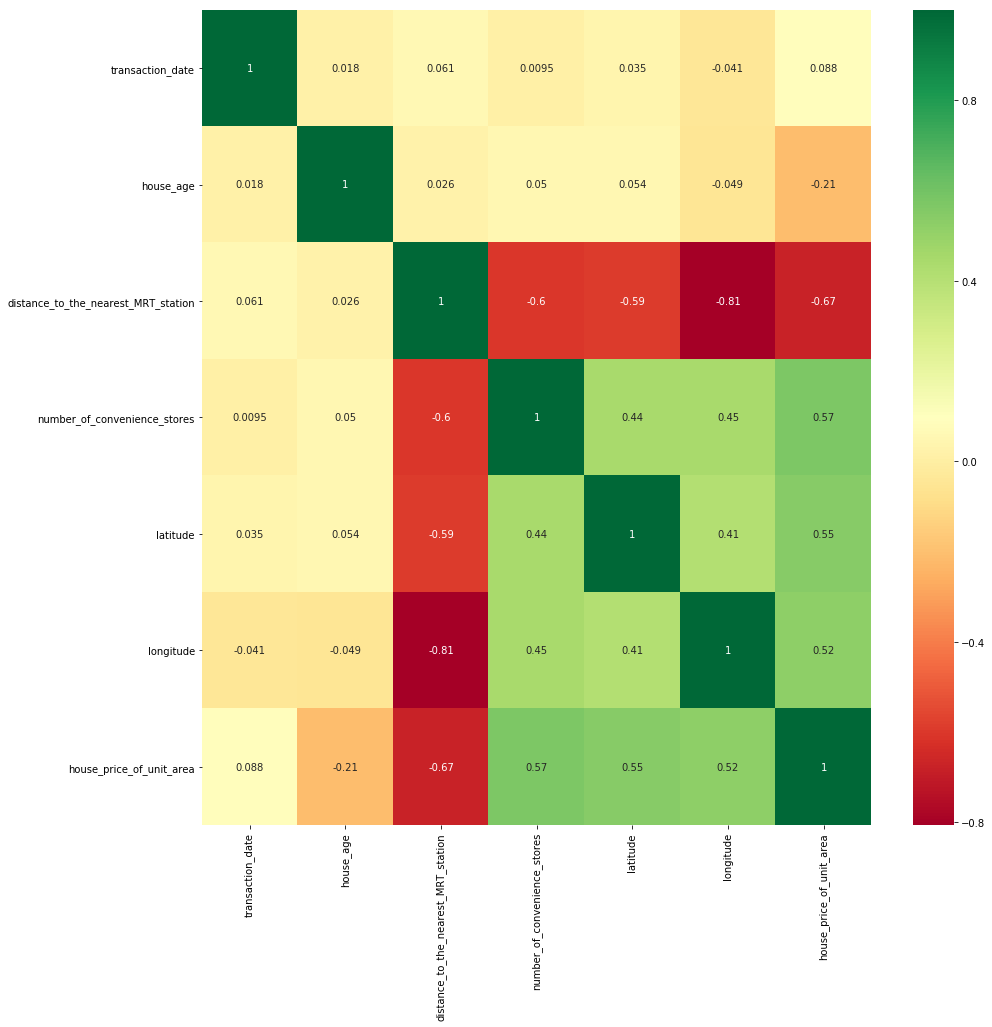

In [91]:
top_corr_features = corr_matrix.index
plt.figure(figsize=(15, 15))

g=sns.heatmap(df[top_corr_features].corr(), annot=True, cmap="RdYlGn")

This visualization makes it easy to just look at the row of `house_price_of_unit_area`, and use the color coordination to get a quick idea of the correlations.

### Visualize Data Geographically

Since we have data that has geograhpic components, we can really benefit from visualizing this data with respect to the globe. To begin, lets visualize the data alone.

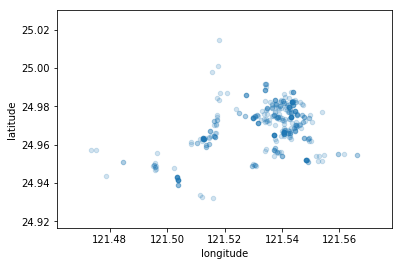

In [92]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2)

Here we can see a few popular clusters of houses.

Now lets visualize Taiwan.

In [186]:
df["geometry"] = list(zip(df.longitude, df.latitude))
geometry = [Point(xy) for xy in zip(df["longitude"], df["latitude"])]
crs = {"init": "epsg:4326"}
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [187]:
geo = gpd.read_file("../data/raw/taiwan_shapefile/Village_NLSC_1041215.shp")

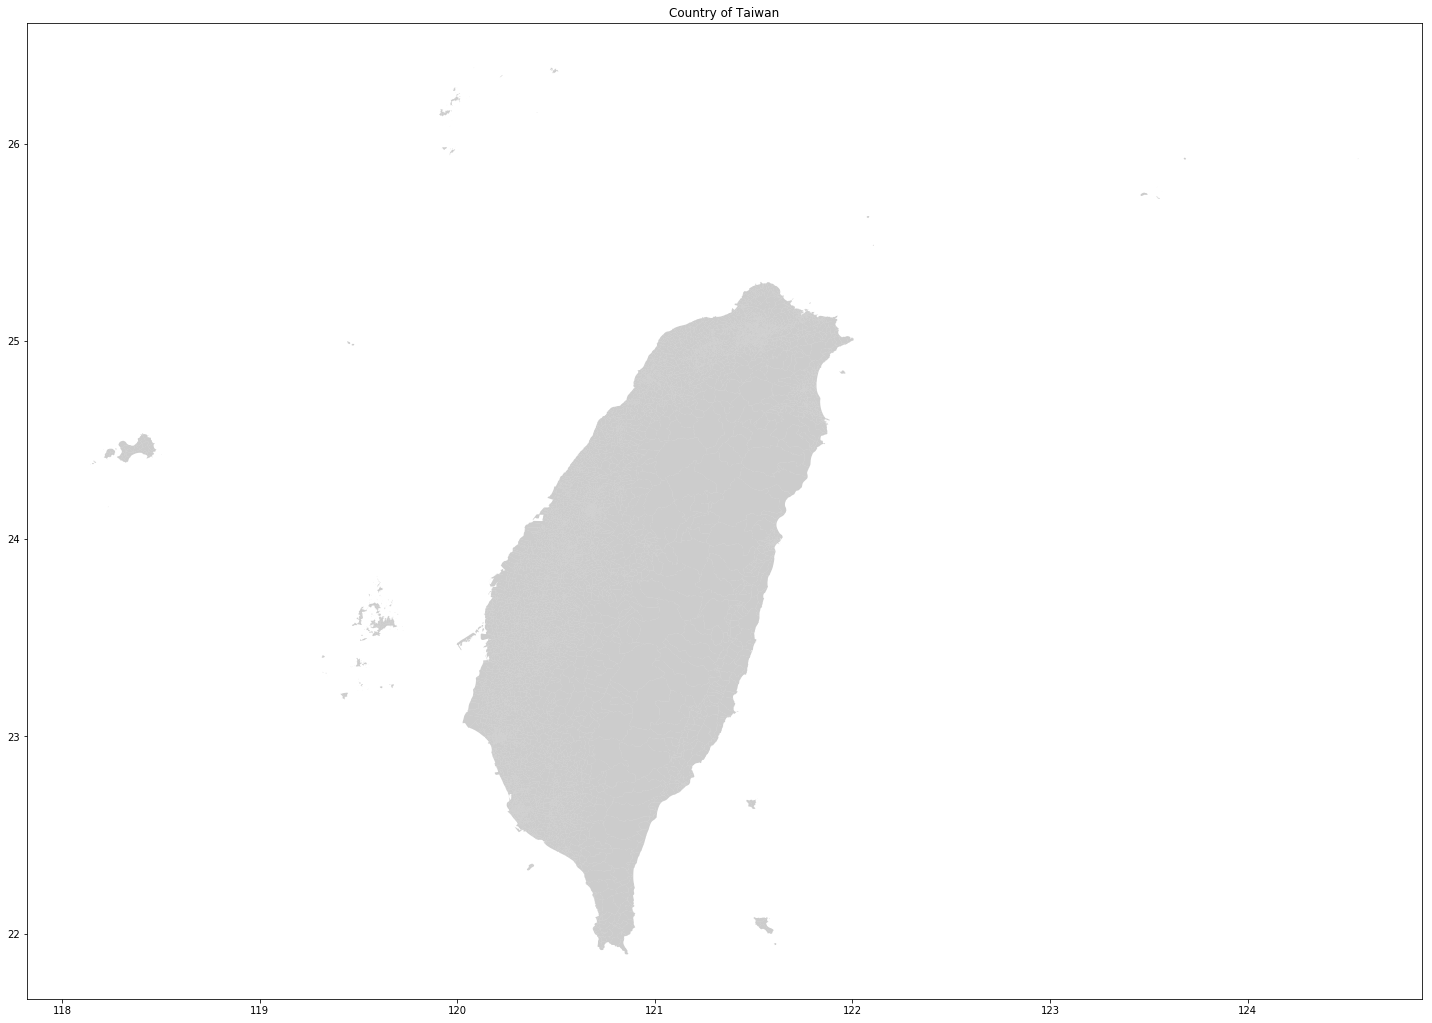

In [204]:
fig, ax = plt.subplots(figsize=(25, 25))
ax.set_title(f"All of Taiwan")
geo.plot(ax=ax, alpha=0.4, color="grey")

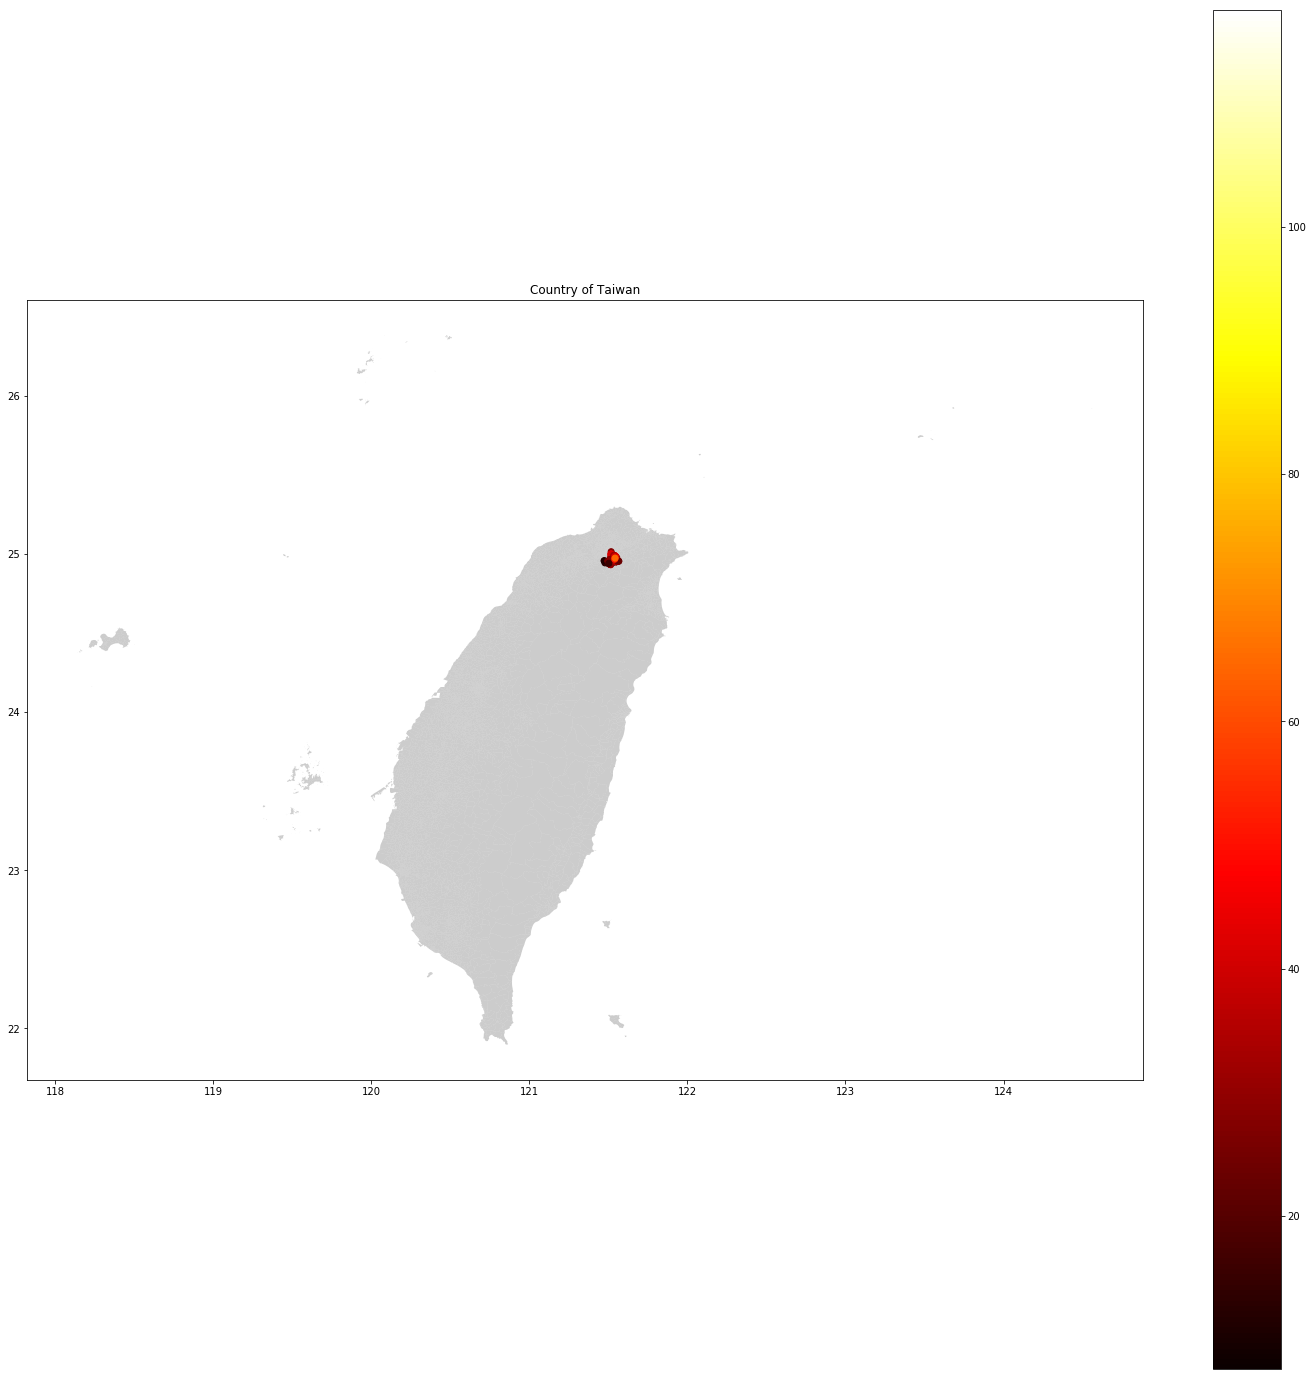

In [205]:
fig, ax = plt.subplots(figsize=(25, 25))
ax.set_title(f"All of Taiwan with house_price_of_unit_area heatmap")
geo.plot(ax=ax, alpha=0.4, color="grey")
geo_df.plot(ax=ax, column="house_price_of_unit_area", cmap="hot", legend=True)

In [ ]:
xmin, ymin, xmax, ymax = geo_df.total_bounds

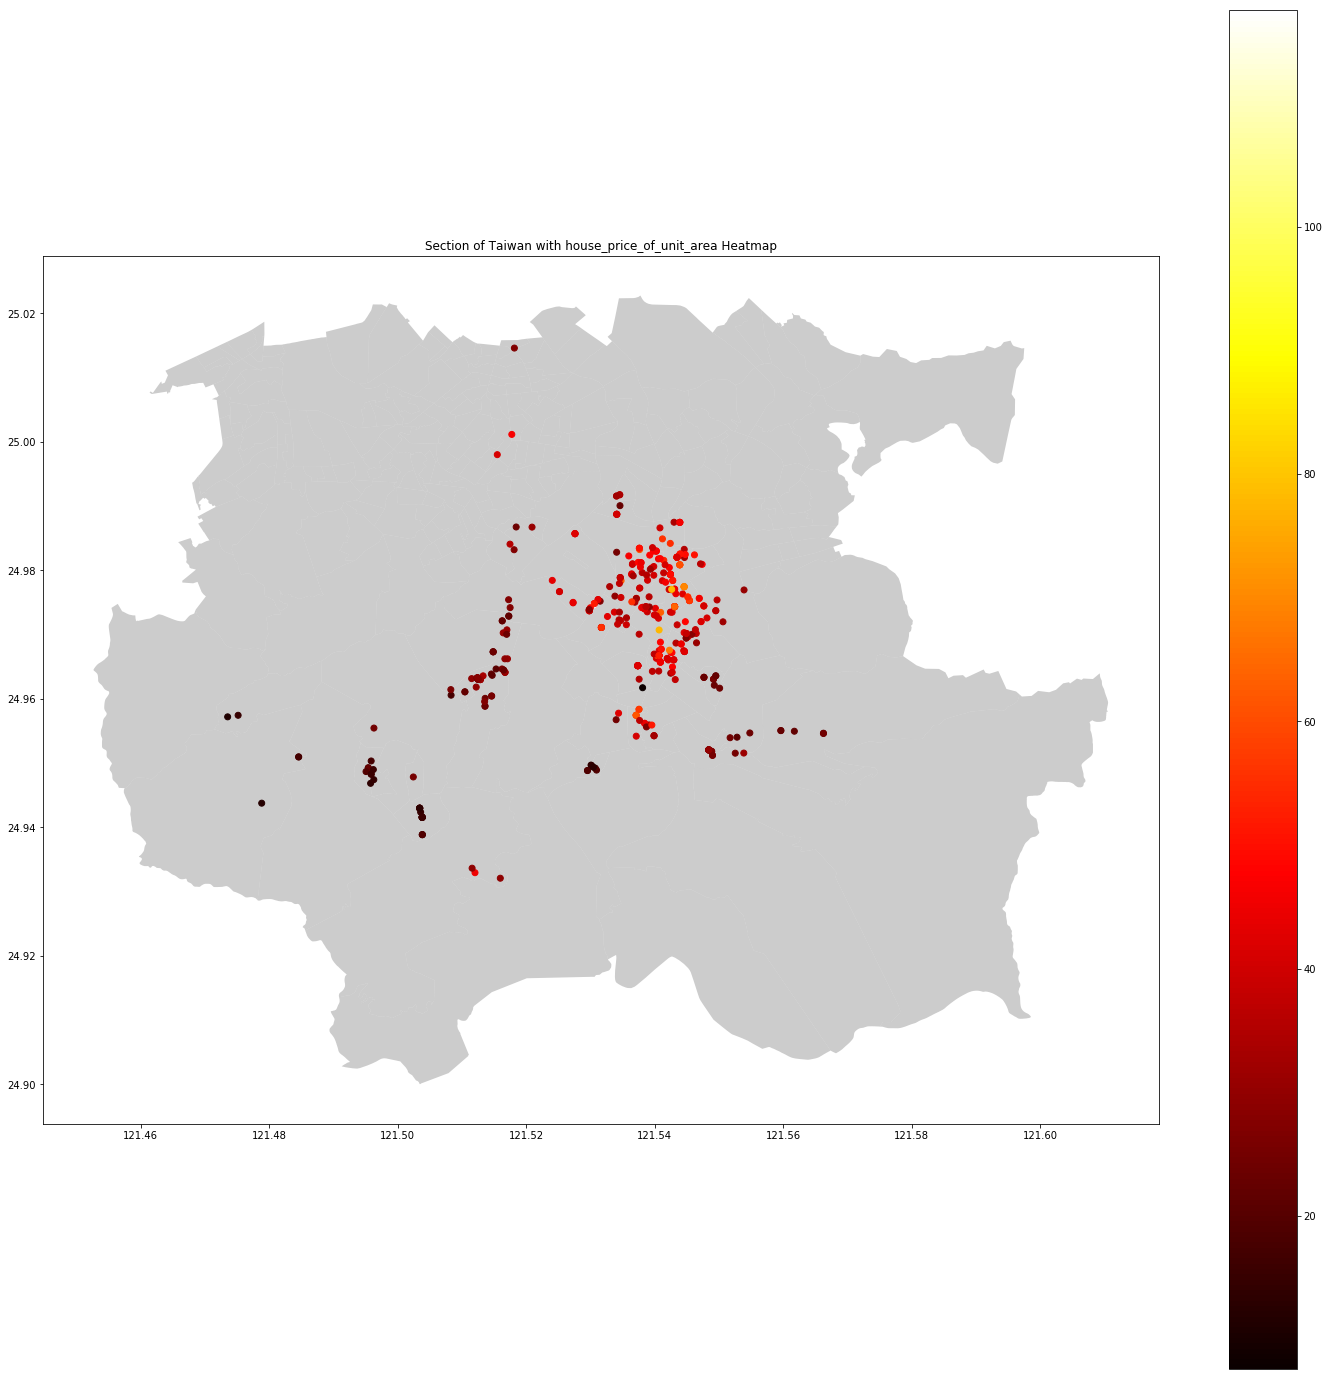

In [210]:
fig, ax = plt.subplots(figsize=(25, 25))
ax.set_title(f"Section of Taiwan with house_price_of_unit_area Heatmap")
xmin, ymin, xmax, ymax = geo_df.total_bounds
sub_shp = geo.cx[xmin:xmax, ymin:ymax]
sub_shp.plot(ax=ax, alpha=0.4, color="grey")
geo_df.plot(ax=ax, column="house_price_of_unit_area", cmap="hot", legend=True)

## Each Column

We'll address each column, starting with the information the [website](https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set) we got the data from and then moving into any observations we have ourselves regarding the data. Then we'll use the `describe` function to get a general feel for the data, along with a violin plot and followed by performing the Shapiro-Wilk test to test for normality. This test was chosen as we have a small number of samples, which is generally a perferred prerequisite for this test. 

Additionally we're going to look for outliers across every column. To do this, I was going to leverage the standard score, also known as the z-score. This score is a measurement of how many standard deviations away from the mean. Unfortunately this score does not make much sense when the data you're working with is not gaussian, which is our case. 

With that in mind, I'll be leveraging a box-and-whisker plot to visualize outliers and use some metric like

> An outlier is any value that's $1.5$ times above or below the interquartile range

_Note: The assumptions were made prior to running the code._

In [93]:
def violin_plot(series: pd.Series):
    """Displays a violin plot for a single Series
    
    """
    sns.violinplot(series).set_title(f"Violin Plot of column {series.name}")
    plt.figure() # ensures this graph does not plot over another graph

In [94]:
def evaluate_missing(series: pd.Series):
    """Displays how many rows are missing for a single Series
    
    """
    print(f"{series.isna().sum()} missing")

In [95]:
def box_plot(series: pd.Series):
    """Displays a Boxplot for a single Series
    
    """
    sns.boxplot(x = series).set_title(f"Boxplot of column {series.name}")
    plt.figure() # ensures this graph does not plot over another graph

In [96]:
def outliers_via_iqr(series: pd.Series):
    """Displays number of outliers using the IQR, for a single Series
    
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    print(f"IQR: {IQR}")
    
    outliers = list(filter(lambda row: (row < (Q1 - 1.5 * IQR)) | (row > (Q3 + 1.5 * IQR)), series))
    print(f"found {len(outliers)} outliers")

In [97]:
def evaluate_outliers(series: pd.Series):
    """Displays how many outliers for a given Series, visually and mathmatically.
    """
    box_plot(series)
    outliers_via_iqr(series)

In [98]:
def qq_plot(series: pd.Series):
    """Displays a QQ plot for a single Series
    
    """
     # visual normality test
    ax = sm.qqplot(series, line='45')
    ax.suptitle(f"Q-Q Plot of column {series.name}")
    plt.figure() # ensures this graph does not plot over another graph

In [99]:
def shapiro_wilk(series: pd.Series, alpha: int = 0.05):
    """Performs the Shapiro-Wilk test, a mathmatical test for normality.
    This test is specifically interested in the tails of a distribution and 
    should not be used with large datasets.
    
    """
    stat, p = shapiro(series)
    
    print(f"\nShapiro-Wilk stat {stat} p {p}")
    
    if p > alpha: 
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [100]:
def test_for_normality(series:pd.Series):
    """Performs a series of tests for normality. Both visual and mathmatical.
    
    """
    qq_plot(series)
    shapiro_wilk(series)

In [101]:
def scatter_plot(x: pd.Series, y: pd.Series):
    """Plots a scatter plot given an X and Y series
    
    """
    sns.scatterplot(x=x, y=y, alpha=0.8).set_title(f"Scatter Plot of {x.name} against {y.name}")
    plt.figure() # ensures this graph does not plot over another graph

In [102]:
def regression_line(x: pd.Series, y: pd.Series):
    """Plots a regression line, showing a linear elationship between 
    X and Y, if any.
    
    """
    
    #sns.regplot(x=x, y=y).set_title(f"Regression Line Plot of {x.name} against {y.name}") # a dufferent regression style
    sns.jointplot(x=x, y=y, kind="regg")
    plt.figure() # ensures this graph does not plot over another graph

In [103]:
def high_level_overview(independent: pd.Series, dependent: pd.Series = None):
    """Gives a high level overview of a single Pandas column.
    
    """
    print(independent.describe())
    violin_plot(independent)
    evaluate_missing(independent)
    evaluate_outliers(independent)
    test_for_normality(independent)
    
    if dependent is not None:
        scatter_plot(independent, dependent)
        regression_line(independent, dependent)

### Independent Variable `transaction_date`

> the transaction date (for example, 2013.250=2013 March, 2013.500=2013 June, etc.)

count     414.000000
mean     2013.148953
std         0.281995
min      2012.666667
25%      2012.916667
50%      2013.166667
75%      2013.416667
max      2013.583333
Name: transaction_date, dtype: float64
0 missing
IQR: 0.5
found 0 outliers

Shapiro-Wilk stat 0.934929370880127 p 1.8203687255496925e-12
Sample does not look Gaussian (reject H0)


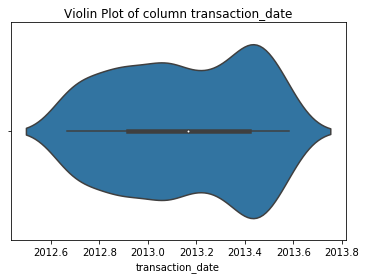

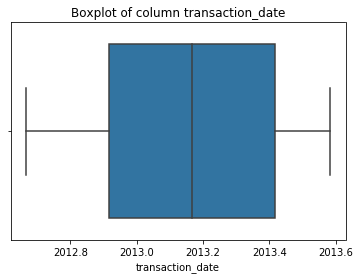

<Figure size 432x288 with 0 Axes>

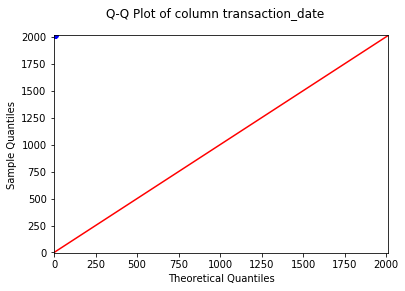

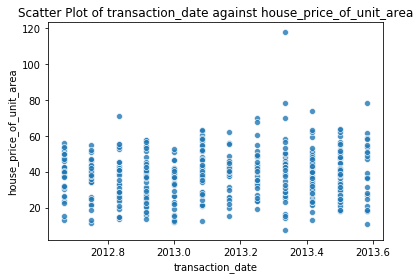

<Figure size 432x288 with 0 Axes>

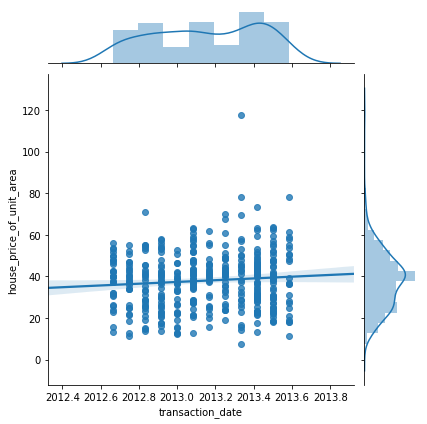

<Figure size 432x288 with 0 Axes>

In [104]:
high_level_overview(df["transaction_date"], df["house_price_of_unit_area"])

- Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
  - date
- Assumptions
  - house_price_of_unit_area and transaction date will have a positive correlation. 
    - I believe as time has gone on, the value of all houses has gone up. This might be due to a bigger population, so demand has gone up and supply has not. I'm drawing from what I know in general in the US, which may not apply to Taiwan.

### Independent Variable `house_age`

> the house age (unit: year)

count    414.000000
mean      17.712560
std       11.392485
min        0.000000
25%        9.025000
50%       16.100000
75%       28.150000
max       43.800000
Name: house_age, dtype: float64
0 missing
IQR: 19.125
found 0 outliers

Shapiro-Wilk stat 0.9467390179634094 p 4.79820315424373e-11
Sample does not look Gaussian (reject H0)


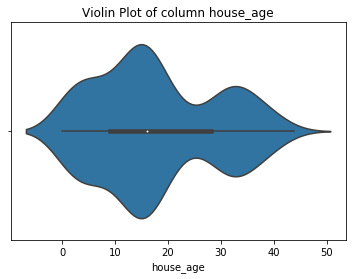

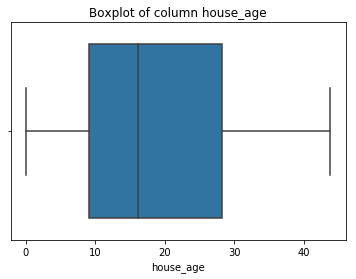

<Figure size 432x288 with 0 Axes>

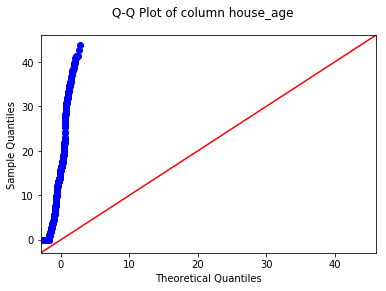

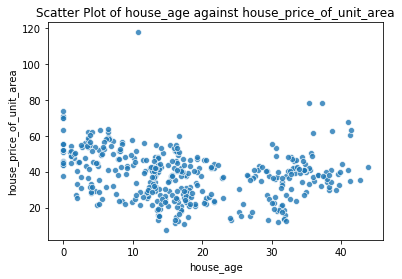

<Figure size 432x288 with 0 Axes>

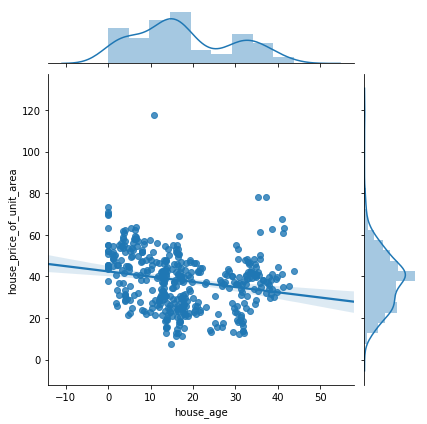

<Figure size 432x288 with 0 Axes>

In [105]:
high_level_overview(df["house_age"], df["house_price_of_unit_area"])

- Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
  - float
- Assumptions
  - `house_age` and `house_price_of_unit_area` will have a negative correlation
    - I believe that newer houses will be worth more. Again, my assumptions are based on what I know of the US. In the US, houses have gotten bigger throughout time. I imagine this trend might exist elsewhere in the world as well.

### Independent Variable `distance_to_the_nearest_MRT_station`

> the distance to the nearest MRT station (unit: meter)

Where MRT = metro rail transit.

count     414.000000
mean     1083.885689
std      1262.109595
min        23.382840
25%       289.324800
50%       492.231300
75%      1454.279000
max      6488.021000
Name: distance_to_the_nearest_MRT_station, dtype: float64
0 missing
IQR: 1164.9542000000001
found 37 outliers

Shapiro-Wilk stat 0.7381015419960022 p 4.8551144525880555e-25
Sample does not look Gaussian (reject H0)


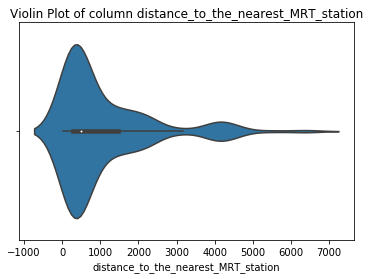

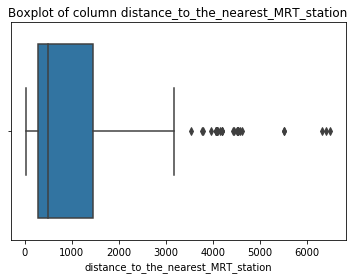

<Figure size 432x288 with 0 Axes>

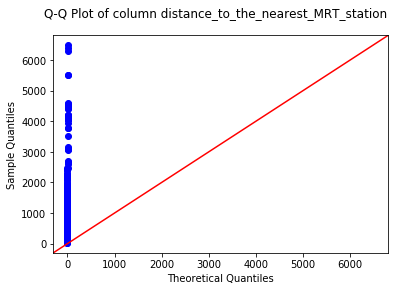

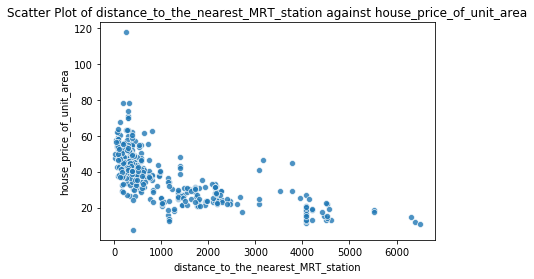

<Figure size 432x288 with 0 Axes>

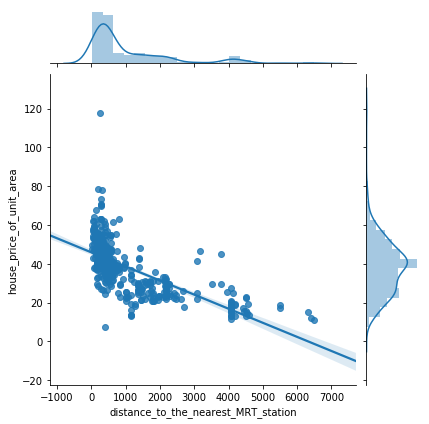

<Figure size 432x288 with 0 Axes>

In [106]:
high_level_overview(df["distance_to_the_nearest_MRT_station"], df["house_price_of_unit_area"])

- Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
  - float
- Assumpions
  - `distance_to_the_nearest_MRT_station` and `house_price_of_unit_area` will have an inverse correlation
    - I believe the distance to a MRT station wil be a good indicator for how urban or rural a house is. Where a smaller measurement will indicate more urban, fetching a higher `house_price_of_unit_area`.

### Independent Variable `number_of_convenience_stores `

> the number of convenience stores in the living circle on foot (integer)

count    414.000000
mean       4.094203
std        2.945562
min        0.000000
25%        1.000000
50%        4.000000
75%        6.000000
max       10.000000
Name: number_of_convenience_stores, dtype: float64
0 missing
IQR: 5.0
found 0 outliers

Shapiro-Wilk stat 0.937370240688324 p 3.458723541946429e-12
Sample does not look Gaussian (reject H0)


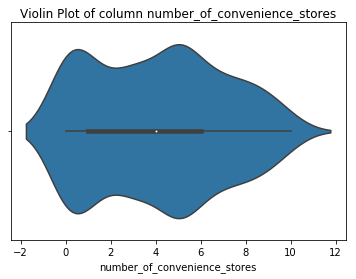

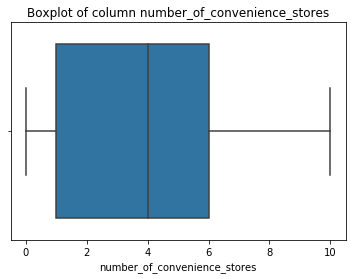

<Figure size 432x288 with 0 Axes>

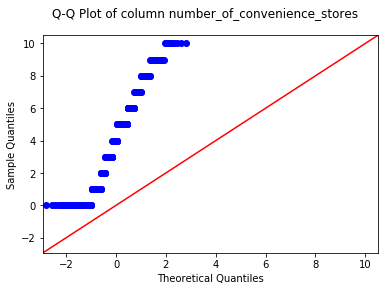

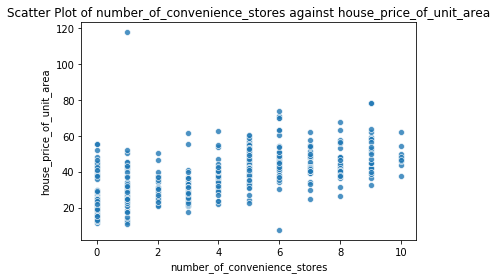

<Figure size 432x288 with 0 Axes>

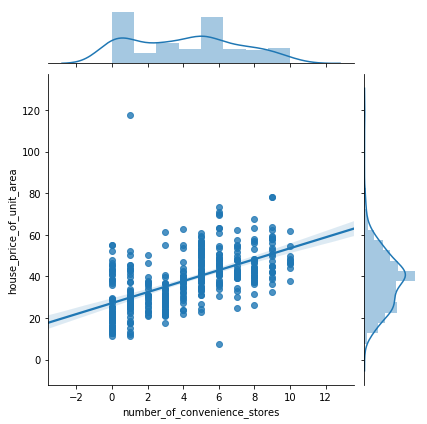

<Figure size 432x288 with 0 Axes>

In [107]:
high_level_overview(df["number_of_convenience_stores"], df["house_price_of_unit_area"])

- Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
  - int
- Assumpions
  - `number_of_convenience_stores` and `house_price_of_unit_area` will have a positive correlation
    - Similiar to `number_of_convenience_stores`, I believe this will be another good measurement of how urban a house is. Again, a larger measurement here will indicate more urban and therefore fetch a higher `house_price_of_unit_area`.

### Independent Variable `latitude`

> the geographic coordinate, latitude. (unit: degree)

count    414.000000
mean      24.969030
std        0.012410
min       24.932070
25%       24.963000
50%       24.971100
75%       24.977455
max       25.014590
Name: latitude, dtype: float64
0 missing
IQR: 0.014454999999998108
found 8 outliers

Shapiro-Wilk stat 0.9732920527458191 p 6.890189752084552e-07
Sample does not look Gaussian (reject H0)


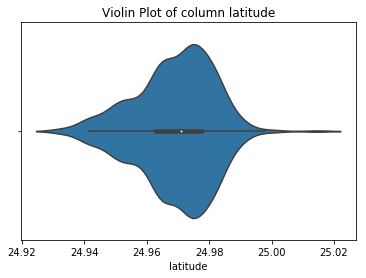

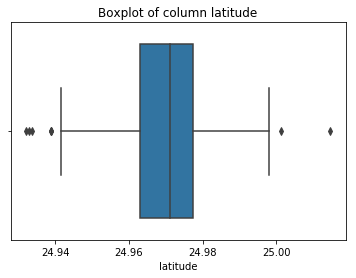

<Figure size 432x288 with 0 Axes>

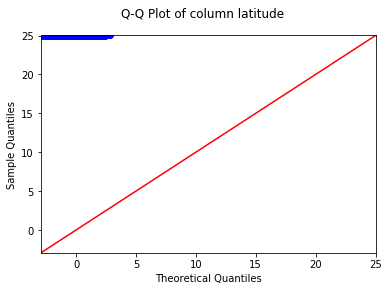

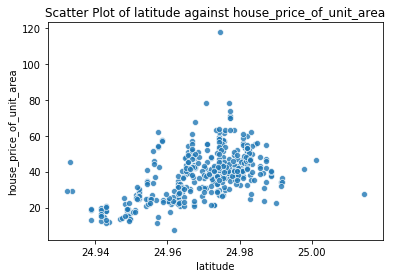

<Figure size 432x288 with 0 Axes>

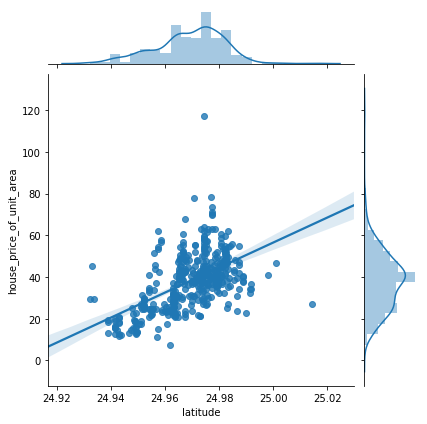

<Figure size 432x288 with 0 Axes>

In [108]:
high_level_overview(df["latitude"], df["house_price_of_unit_area"])

- Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
  - float
- Assumptions
  - `latitude` and `house_price_of_unit_area` will have a parabolic correlation
    - Since New Taipei City has water on its East and West, I believe the smallest `latitude` and largest `latitude` values will equate to larger `house_price_of_unit_area` due to waterfront properties.

### Independent Variable `longitude`

> the geographic coordinate, longitude. (unit: degree)

count    414.000000
mean     121.533361
std        0.015347
min      121.473530
25%      121.528085
50%      121.538630
75%      121.543305
max      121.566270
Name: longitude, dtype: float64
0 missing
IQR: 0.015219999999999345
found 35 outliers

Shapiro-Wilk stat 0.8708114624023438 p 4.545777673730064e-18
Sample does not look Gaussian (reject H0)


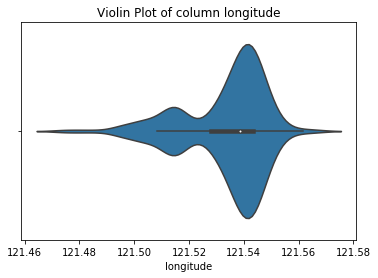

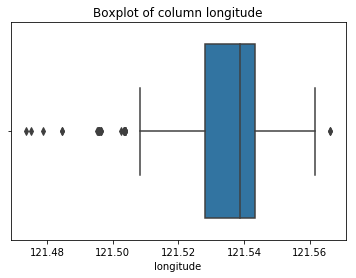

<Figure size 432x288 with 0 Axes>

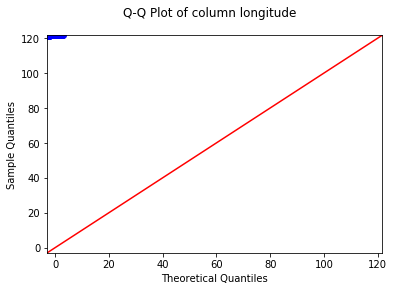

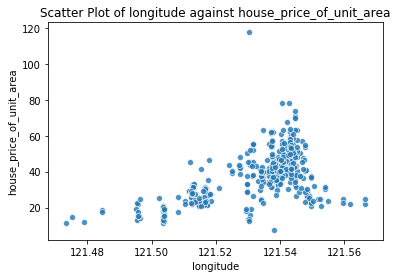

<Figure size 432x288 with 0 Axes>

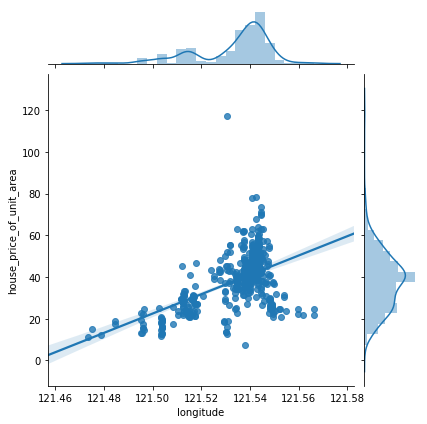

<Figure size 432x288 with 0 Axes>

In [109]:
high_level_overview(df["longitude"], df["house_price_of_unit_area"])

- Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
  - float
- Assumptions
  - `longitude` and `house_price_of_unit_area` and will have a positive correlation
    - New Taipei City is a city bordered by water to the north, so I believe a higher `latitude` will relate to a more coastal city, resulting in a larger `house_price_of_unit_area`.

### Dependent Variable `house_price_of_unit_area`

> house price of unit area (10000 New Taiwan Dollar/Ping, where Ping is a local unit, 1 Ping = 3.3 meter squared) 

count    414.000000
mean      37.980193
std       13.606488
min        7.600000
25%       27.700000
50%       38.450000
75%       46.600000
max      117.500000
Name: house_price_of_unit_area, dtype: float64
0 missing
IQR: 18.900000000000002
found 3 outliers

Shapiro-Wilk stat 0.972750186920166 p 5.412278483163391e-07
Sample does not look Gaussian (reject H0)


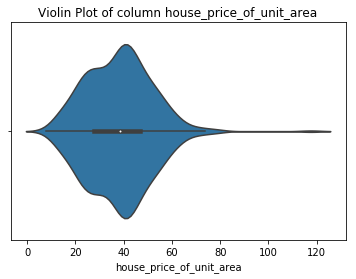

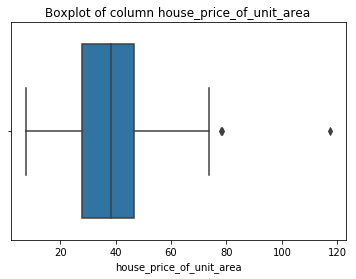

<Figure size 432x288 with 0 Axes>

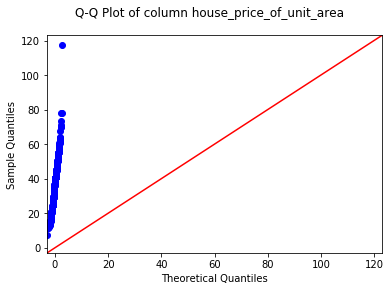

<Figure size 432x288 with 0 Axes>

In [110]:
high_level_overview(df["house_price_of_unit_area"])

Dependent variable.

- Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
  - float

## Part D: Prepare the Data

Notes:
  - Work on copies of the data (keep the original dataset intact).
  - Write functions for all data transformations you apply, for five reasons:
    1. So you can easily prepare the data the next time you get a fresh dataset
    2. So you can apply these transformations in future projects
    3. To clean and prepare the test set
    4. To clean and prepare new data instances once your solution is live
    5. To make it easy to treat your preparation choices as hyperparameters
    
1. Data cleaning:
  - Fix or remove outliers (optional).
    - I have read that this is a big no no and I will not proceed with removing or "fixing" outliers.
  - Fill in missing values (e.g., with zero, mean, median...) or drop their rows (or columns).
2. Feature selection(optional):
  - Drop the attributes that provide no useful information for the task.
3. Feature engineering, where appropriate:
  - Discretize continuous features.
  - Decompose features (e.g., categorical, date/time, etc.).
  - Add promising transformations of features (e.g., log(x), sqrt(x), x^2, etc.).
  - Aggregate features into promising new features.
4. Feature scaling: standardize or normalize features.

First we'll start by creating a copy of the data, so we can keep the original intack.

In [143]:
df_clean = df.copy()

### Data Cleaning

#### Outliers

We will not be removing any outliers or "fixing" them. I have no sources or proof that any of these outliers are bad data.

#### Missing Values

No columns have any missing data, so no data imputation techniques will be used.

#### Fixing D-Types

`transaction_date` has a `float64` dtype, where it could have a `datetime` dtype. We'll levage the `pandas.read_csv`'s ability to pass in a custom `parse_dates` function to write our own parser.

- https://stackoverflow.com/questions/21269399/datetime-dtypes-in-pandas-read-csv
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html#pandas.to_datetime
- https://stackoverflow.com/questions/23797491/parse-dates-in-pandas

We leverage the [datetime.strptime format codes](https://docs.python.org/3.4/library/datetime.html#strftime-strptime-behavior) to make the parsing incredibly easy.

In [144]:
def month_decimal_to_index(s: str) -> int:
    """Converts the weird encoding deciaml that this data set had to an actual month.
    EX: '2013.250' -> 3, for March, the third month of the year
    
    """
    DECIMAL_VALUE_PER_MONTH = 1.00/12
    return int(float('.' + s.split('.')[1])//DECIMAL_VALUE_PER_MONTH + 1) # we reattach the '.' we split on, as it is a decimal and we want to use it

In [145]:
def weird_date_to_normalized_year_month(weird_date_format: float):
    month_as_int = month_decimal_to_index(str(weird_date_format))
    
    return str(weird_date_format).split('.')[0] + '.' + str(month_as_int)

In [146]:
df_clean["transaction_date"] = df_clean["transaction_date"].apply(weird_date_to_normalized_year_month)

At this point, our column is now formatted from the strange percentage of the year, to an actual month. Where $1$ represents January and $12$ represents December. We'll now use Pandas' ability to parse these into a new dtype.

In [147]:
df_clean["transaction_date"] = df_clean["transaction_date"].apply(lambda date: pd.datetime.strptime(str(date), "%Y.%m"))

In [148]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 1 to 414
Data columns (total 7 columns):
transaction_date                       414 non-null datetime64[ns]
house_age                              414 non-null float64
distance_to_the_nearest_MRT_station    414 non-null float64
number_of_convenience_stores           414 non-null int64
latitude                               414 non-null float64
longitude                              414 non-null float64
house_price_of_unit_area               414 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 25.9 KB


And now Pandas knows our `transaction_date` is a `datetime64` dtype. 

Its important to note that the original data did not encode day of the month, nor time. So I assumed the 1st of each month. Perhaps their fraction had the intent to encode the day, hour, minute, second but sense they did not show it in their examples, I will not try to decode this. 

The last step we have is converting from `datetime64` to `datetime`. We do this because of [this SO post](https://stackoverflow.com/a/49758140/1983957).

In [149]:
df_clean["transaction_date"] = df_clean["transaction_date"].dt.to_pydatetime()
# df_clean["transaction_date"] = df_clean["transaction_date"].dt.date
# df_clean["transaction_date"].astype("datetime")

In [150]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 1 to 414
Data columns (total 7 columns):
transaction_date                       414 non-null datetime64[ns]
house_age                              414 non-null float64
distance_to_the_nearest_MRT_station    414 non-null float64
number_of_convenience_stores           414 non-null int64
latitude                               414 non-null float64
longitude                              414 non-null float64
house_price_of_unit_area               414 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 25.9 KB


In [151]:
df_clean.head()

,transaction_date,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area
No,,,,,,,
1,2012-12-01,32.0,84.87882,10,24.98298,121.54024,37.9
2,2012-12-01,19.5,306.59470,9,24.98034,121.53951,42.2
3,2013-07-01,13.3,561.98450,5,24.98746,121.54391,47.3
4,2013-07-01,13.3,561.98450,5,24.98746,121.54391,54.8
5,2012-10-01,5.0,390.56840,5,24.97937,121.54245,43.1


TODO figure out why above isn't converting the dtype to `datetime`

### Feature Engineering

We're going to experiment with creating our own columns based on other columns in the dataset.

### `urbanness`

In [152]:
df_clean["urbanness"] = df_clean["number_of_convenience_stores"] / df["distance_to_the_nearest_MRT_station"]

In [153]:
df_clean.head()

,transaction_date,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area,urbanness
No,,,,,,,,
1,2012-12-01,32.0,84.87882,10,24.98298,121.54024,37.9,0.117815
2,2012-12-01,19.5,306.59470,9,24.98034,121.53951,42.2,0.029355
3,2013-07-01,13.3,561.98450,5,24.98746,121.54391,47.3,0.008897
4,2013-07-01,13.3,561.98450,5,24.98746,121.54391,54.8,0.008897
5,2012-10-01,5.0,390.56840,5,24.97937,121.54245,43.1,0.012802


Now we'll look at the correlation matrix again.

In [154]:
corr_matrix = df_clean.corr()
corr_matrix["house_price_of_unit_area"].sort_values(ascending=False)

house_price_of_unit_area               1.000000
number_of_convenience_stores           0.571005
latitude                               0.546307
longitude                              0.523287
urbanness                              0.431922
house_age                             -0.210567
distance_to_the_nearest_MRT_station   -0.673613
Name: house_price_of_unit_area, dtype: float64

We can see that our `urbanness` column has a positive correlation with `house_price_of_unit_area`, which was what we predicted in our initial EDA.

### `transaction_year`

We'll be extracting the year value from the `transaction_date`. This should make it easier for our models to interpret which year a transaction occurred.

In [155]:
df_clean["transaction_year"] = df_clean["transaction_date"].map(lambda x:  x.year)

In [156]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 1 to 414
Data columns (total 9 columns):
transaction_date                       414 non-null datetime64[ns]
house_age                              414 non-null float64
distance_to_the_nearest_MRT_station    414 non-null float64
number_of_convenience_stores           414 non-null int64
latitude                               414 non-null float64
longitude                              414 non-null float64
house_price_of_unit_area               414 non-null float64
urbanness                              414 non-null float64
transaction_year                       414 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 32.3 KB


In [157]:
df_clean.head()

,transaction_date,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area,urbanness,transaction_year
No,,,,,,,,,
1,2012-12-01,32.0,84.87882,10,24.98298,121.54024,37.9,0.117815,2012
2,2012-12-01,19.5,306.59470,9,24.98034,121.53951,42.2,0.029355,2012
3,2013-07-01,13.3,561.98450,5,24.98746,121.54391,47.3,0.008897,2013
4,2013-07-01,13.3,561.98450,5,24.98746,121.54391,54.8,0.008897,2013
5,2012-10-01,5.0,390.56840,5,24.97937,121.54245,43.1,0.012802,2012


In [158]:
df_clean["transaction_year"].value_counts(sort=False)

2012    126
2013    288
Name: transaction_year, dtype: int64

Its important to remember that we have more than $2$ times the number of data points in $2013$ than $2012$.

### `transaction_month`

We'll be extracting the month value from the `transaction_date`. This should make it easier for our models to interpret which month a transaction occurred.

In [159]:
df_clean["transaction_month"] = df_clean["transaction_date"].map(lambda x:  x.month)

In [160]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 1 to 414
Data columns (total 10 columns):
transaction_date                       414 non-null datetime64[ns]
house_age                              414 non-null float64
distance_to_the_nearest_MRT_station    414 non-null float64
number_of_convenience_stores           414 non-null int64
latitude                               414 non-null float64
longitude                              414 non-null float64
house_price_of_unit_area               414 non-null float64
urbanness                              414 non-null float64
transaction_year                       414 non-null int64
transaction_month                      414 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 35.6 KB


In [161]:
df_clean.head()

,transaction_date,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area,urbanness,transaction_year,transaction_month
No,,,,,,,,,,
1,2012-12-01,32.0,84.87882,10,24.98298,121.54024,37.9,0.117815,2012,12
2,2012-12-01,19.5,306.59470,9,24.98034,121.53951,42.2,0.029355,2012,12
3,2013-07-01,13.3,561.98450,5,24.98746,121.54391,47.3,0.008897,2013,7
4,2013-07-01,13.3,561.98450,5,24.98746,121.54391,54.8,0.008897,2013,7
5,2012-10-01,5.0,390.56840,5,24.97937,121.54245,43.1,0.012802,2012,10


In [162]:
df_clean["transaction_month"].value_counts(sort=False)

1     74
3     25
4     61
6     58
7     70
9     30
10    58
12    38
Name: transaction_month, dtype: int64

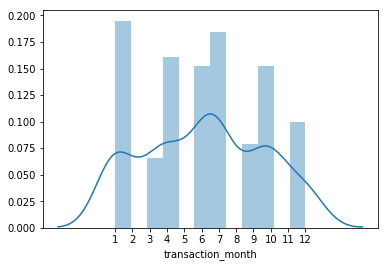

In [163]:
plt.xticks(range(1, 13))
sns.distplot(df_clean["transaction_month"], bins=12)

Here we can see that there are many months that don't have any data recorded for them. 

### Feature Scaling

Generally, models don't work particularly well when numerical independent variables are in different scales from each other. What can happen is larger scaled independent variables can overshadow in importance, the smaller scaled independent variables. So a technique we can do is to scale our numerical models, all on the same scale, to give them each the same oppurtunity to be important. We have many options for scaling our independent variables:

- "standard scaler"
- "min-max scaler"
- "robust scaler"
- "normalizer"

While I originally planned on using the standard scaler, we've already demonstrated that our independent columns are not gaussian, so we will skip this technique. The next technique min-max scaler seems to be the most widely used technique but the problem is that our independent variables have outliers as we previously demonstrated. That brings us to our third technique, the robust scaler, which is more resistant to outliers. For that reason, we will be using the robust scaler to scale our numerical independent variables.

Used [this link](http://benalexkeen.com/feature-scaling-with-scikit-learn/) to learn about scaling. [This link](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) demonstrates what can happen by using different scalers.

Before we scale, lets reobserve the information regarding our independent variables.

In [132]:
df_clean.describe()

,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area,urbanness,transaction_year,transaction_month
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193,0.018156,2012.695652,6.128019
std,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488,0.032965,0.460687,3.461380
min,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000,0.000000,2012.000000,1.000000
25%,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000,0.001155,2012.000000,4.000000
50%,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000,0.007498,2013.000000,6.000000
75%,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000,0.018835,2013.000000,9.000000
max,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000,0.299365,2013.000000,12.000000


We'll look at this exact output above, post sacling.

In [133]:
X = df_clean[["number_of_convenience_stores", "latitude", "longitude", "urbanness", "house_age", "distance_to_the_nearest_MRT_station"]] # we had to exclude our date column
Y = df_clean[["house_price_of_unit_area"]]

In [134]:
scaler = RobustScaler().fit(X)
df_clean[["number_of_convenience_stores", "latitude", "longitude", "urbanness", "house_age", "distance_to_the_nearest_MRT_station"]] = scaler.fit_transform(X)
df_clean.head()

,transaction_date,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area,urbanness,transaction_year,transaction_month
No,,,,,,,,,,
1,2012-12-01,0.831373,-0.349673,1.2,0.821861,0.105782,37.9,6.239678,2012,12
2,2012-12-01,0.177778,-0.159351,1.0,0.639225,0.057819,42.2,1.236245,2012,12
3,2013-07-01,-0.146405,0.059876,0.2,1.131788,0.346912,47.3,0.079132,2013,7
4,2013-07-01,-0.146405,0.059876,0.2,1.131788,0.346912,54.8,0.079132,2013,7
5,2012-10-01,-0.580392,-0.087268,0.2,0.572120,0.250986,43.1,0.299994,2012,10


In [135]:
df_clean.describe()

,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area,urbanness,transaction_year,transaction_month
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,0.084317,0.507878,0.018841,-0.143198,-0.346184,37.980193,0.602815,2012.695652,6.128019
std,0.595685,1.083398,0.589112,0.858540,1.008356,13.606488,1.864523,0.460687,3.461380
min,-0.841830,-0.402461,-0.800000,-2.700104,-4.277267,7.600000,-0.424096,2012.000000,1.000000
25%,-0.369935,-0.174176,-0.600000,-0.560360,-0.692838,27.700000,-0.358744,2012.000000,4.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,38.450000,0.000000,2013.000000,6.000000
75%,0.630065,0.825824,0.400000,0.439640,0.307162,46.600000,0.641256,2013.000000,9.000000
max,1.448366,5.146803,1.200000,3.008648,1.816032,117.500000,16.508377,2013.000000,12.000000


### `longitude`

We'll apply binning to `longitude` to hopefully improve our models' interpretation of the independent variable.

### `latitude`

We'll apply binning to `latitude` to hopefully improve our models' interpretation of the independent variable.

### Feature Selection

Why do we perform feature selection? For three benefits of performing feature selection before modeling your data are:

1. Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.
2. Improves Accuracy: Less misleading data means modeling accuracy improves.
3. Reduces Training Time: Less data means that algorithms train faster.

Additionally, there are four different techniques for performing feature selection:


1. Forward Selection: The procedure starts with an empty set of features [reduced set]. The best of the original features is determined and added to the reduced set. At each subsequent iteration, the best of the remaining original attributes is added to the set.
2. Backward Elimination: The procedure starts with the full set of attributes. At each step, it removes the worst attribute remaining in the set.
3. Combination of forward selection and backward elimination: The stepwise forward selection and backward elimination methods can be combined so that, at each step, the procedure selects the best attribute and removes the worst from among the remaining attributes.
4. Recursive Feature elimination: Recursive feature elimination performs a greedy search to find the best performing feature subset. It iteratively creates models and determines the best or the worst performing feature at each iteration. It constructs the subsequent models with the left features until all the features are explored. It then ranks the features based on the order of their elimination. In the worst case, if a dataset contains N number of features RFE will do a greedy search for 2N combinations of features.



We'll address each column and determine if any are not good predictors of the dependent variable.


Used [this link](https://machinelearningmastery.com/feature-selection-machine-learning-python/) and [this link](https://www.datacamp.com/community/tutorials/feature-selection-python), as I don't believe the "Hands-On Machine Learning" book does enough on this section.

In [136]:
# Import the necessary libraries first
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [137]:
# Feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, Y)

# Summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)

features = fit.transform(X)
# Summarize selected features
features

ValueError: Unknown label type: (array([[ 37.9],
       [ 42.2],
       [ 47.3],
       [ 54.8],
       [ 43.1],
       [ 32.1],
       [ 40.3],
       [ 46.7],
       [ 18.8],
       [ 22.1],
       [ 41.4],
       [ 58.1],
       [ 39.3],
       [ 23.8],
       [ 34.3],
       [ 50.5],
       [ 70.1],
       [ 37.4],
       [ 42.3],
       [ 47.7],
       [ 29.3],
       [ 51.6],
       [ 24.6],
       [ 47.9],
       [ 38.8],
       [ 27. ],
       [ 56.2],
       [ 33.6],
       [ 47. ],
       [ 57.1],
       [ 22.1],
       [ 25. ],
       [ 34.2],
       [ 49.3],
       [ 55.1],
       [ 27.3],
       [ 22.9],
       [ 25.3],
       [ 47.7],
       [ 46.2],
       [ 15.9],
       [ 18.2],
       [ 34.7],
       [ 34.1],
       [ 53.9],
       [ 38.3],
       [ 42. ],
       [ 61.5],
       [ 13.4],
       [ 13.2],
       [ 44.2],
       [ 20.7],
       [ 27. ],
       [ 38.9],
       [ 51.7],
       [ 13.7],
       [ 41.9],
       [ 53.5],
       [ 22.6],
       [ 42.4],
       [ 21.3],
       [ 63.2],
       [ 27.7],
       [ 55. ],
       [ 25.3],
       [ 44.3],
       [ 50.7],
       [ 56.8],
       [ 36.2],
       [ 42. ],
       [ 59. ],
       [ 40.8],
       [ 36.3],
       [ 20. ],
       [ 54.4],
       [ 29.5],
       [ 36.8],
       [ 25.6],
       [ 29.8],
       [ 26.5],
       [ 40.3],
       [ 36.8],
       [ 48.1],
       [ 17.7],
       [ 43.7],
       [ 50.8],
       [ 27. ],
       [ 18.3],
       [ 48. ],
       [ 25.3],
       [ 45.4],
       [ 43.2],
       [ 21.8],
       [ 16.1],
       [ 41. ],
       [ 51.8],
       [ 59.5],
       [ 34.6],
       [ 51. ],
       [ 62.2],
       [ 38.2],
       [ 32.9],
       [ 54.4],
       [ 45.7],
       [ 30.5],
       [ 71. ],
       [ 47.1],
       [ 26.6],
       [ 34.1],
       [ 28.4],
       [ 51.6],
       [ 39.4],
       [ 23.1],
       [  7.6],
       [ 53.3],
       [ 46.4],
       [ 12.2],
       [ 13. ],
       [ 30.6],
       [ 59.6],
       [ 31.3],
       [ 48. ],
       [ 32.5],
       [ 45.5],
       [ 57.4],
       [ 48.6],
       [ 62.9],
       [ 55. ],
       [ 60.7],
       [ 41. ],
       [ 37.5],
       [ 30.7],
       [ 37.5],
       [ 39.5],
       [ 42.2],
       [ 20.8],
       [ 46.8],
       [ 47.4],
       [ 43.5],
       [ 42.5],
       [ 51.4],
       [ 28.9],
       [ 37.5],
       [ 40.1],
       [ 28.4],
       [ 45.5],
       [ 52.2],
       [ 43.2],
       [ 45.1],
       [ 39.7],
       [ 48.5],
       [ 44.7],
       [ 28.9],
       [ 40.9],
       [ 20.7],
       [ 15.6],
       [ 18.3],
       [ 35.6],
       [ 39.4],
       [ 37.4],
       [ 57.8],
       [ 39.6],
       [ 11.6],
       [ 55.5],
       [ 55.2],
       [ 30.6],
       [ 73.6],
       [ 43.4],
       [ 37.4],
       [ 23.5],
       [ 14.4],
       [ 58.8],
       [ 58.1],
       [ 35.1],
       [ 45.2],
       [ 36.5],
       [ 19.2],
       [ 42. ],
       [ 36.7],
       [ 42.6],
       [ 15.5],
       [ 55.9],
       [ 23.6],
       [ 18.8],
       [ 21.8],
       [ 21.5],
       [ 25.7],
       [ 22. ],
       [ 44.3],
       [ 20.5],
       [ 42.3],
       [ 37.8],
       [ 42.7],
       [ 49.3],
       [ 29.3],
       [ 34.6],
       [ 36.6],
       [ 48.2],
       [ 39.1],
       [ 31.6],
       [ 25.5],
       [ 45.9],
       [ 31.5],
       [ 46.1],
       [ 26.6],
       [ 21.4],
       [ 44. ],
       [ 34.2],
       [ 26.2],
       [ 40.9],
       [ 52.2],
       [ 43.5],
       [ 31.1],
       [ 58. ],
       [ 20.9],
       [ 48.1],
       [ 39.7],
       [ 40.8],
       [ 43.8],
       [ 40.2],
       [ 78.3],
       [ 38.5],
       [ 48.5],
       [ 42.3],
       [ 46. ],
       [ 49. ],
       [ 12.8],
       [ 40.2],
       [ 46.6],
       [ 19. ],
       [ 33.4],
       [ 14.7],
       [ 17.4],
       [ 32.4],
       [ 23.9],
       [ 39.3],
       [ 61.9],
       [ 39. ],
       [ 40.6],
       [ 29.7],
       [ 28.8],
       [ 41.4],
       [ 33.4],
       [ 48.2],
       [ 21.7],
       [ 40.8],
       [ 40.6],
       [ 23.1],
       [ 22.3],
       [ 15. ],
       [ 30. ],
       [ 13.8],
       [ 52.7],
       [ 25.9],
       [ 51.8],
       [ 17.4],
       [ 26.5],
       [ 43.9],
       [ 63.3],
       [ 28.8],
       [ 30.7],
       [ 24.4],
       [ 53. ],
       [ 31.7],
       [ 40.6],
       [ 38.1],
       [ 23.7],
       [ 41.1],
       [ 40.1],
       [ 23. ],
       [117.5],
       [ 26.5],
       [ 40.5],
       [ 29.3],
       [ 41. ],
       [ 49.7],
       [ 34. ],
       [ 27.7],
       [ 44. ],
       [ 31.1],
       [ 45.4],
       [ 44.8],
       [ 25.6],
       [ 23.5],
       [ 34.4],
       [ 55.3],
       [ 56.3],
       [ 32.9],
       [ 51. ],
       [ 44.5],
       [ 37. ],
       [ 54.4],
       [ 24.5],
       [ 42.5],
       [ 38.1],
       [ 21.8],
       [ 34.1],
       [ 28.5],
       [ 16.7],
       [ 46.1],
       [ 36.9],
       [ 35.7],
       [ 23.2],
       [ 38.4],
       [ 29.4],
       [ 55. ],
       [ 50.2],
       [ 24.7],
       [ 53. ],
       [ 19.1],
       [ 24.7],
       [ 42.2],
       [ 78. ],
       [ 42.8],
       [ 41.6],
       [ 27.3],
       [ 42. ],
       [ 37.5],
       [ 49.8],
       [ 26.9],
       [ 18.6],
       [ 37.7],
       [ 33.1],
       [ 42.5],
       [ 31.3],
       [ 38.1],
       [ 62.1],
       [ 36.7],
       [ 23.6],
       [ 19.2],
       [ 12.8],
       [ 15.6],
       [ 39.6],
       [ 38.4],
       [ 22.8],
       [ 36.5],
       [ 35.6],
       [ 30.9],
       [ 36.3],
       [ 50.4],
       [ 42.9],
       [ 37. ],
       [ 53.5],
       [ 46.6],
       [ 41.2],
       [ 37.9],
       [ 30.8],
       [ 11.2],
       [ 53.7],
       [ 47. ],
       [ 42.3],
       [ 28.6],
       [ 25.7],
       [ 31.3],
       [ 30.1],
       [ 60.7],
       [ 45.3],
       [ 44.9],
       [ 45.1],
       [ 24.7],
       [ 47.1],
       [ 63.3],
       [ 40. ],
       [ 48. ],
       [ 33.1],
       [ 29.5],
       [ 24.8],
       [ 20.9],
       [ 43.1],
       [ 22.8],
       [ 42.1],
       [ 51.7],
       [ 41.5],
       [ 52.2],
       [ 49.5],
       [ 23.8],
       [ 30.5],
       [ 56.8],
       [ 37.4],
       [ 69.7],
       [ 53.3],
       [ 47.3],
       [ 29.3],
       [ 40.3],
       [ 12.9],
       [ 46.6],
       [ 55.3],
       [ 25.6],
       [ 27.3],
       [ 67.7],
       [ 38.6],
       [ 31.3],
       [ 35.3],
       [ 40.3],
       [ 24.7],
       [ 42.5],
       [ 31.9],
       [ 32.2],
       [ 23. ],
       [ 37.3],
       [ 35.5],
       [ 27.7],
       [ 28.5],
       [ 39.7],
       [ 41.2],
       [ 37.2],
       [ 40.5],
       [ 22.3],
       [ 28.1],
       [ 15.4],
       [ 50. ],
       [ 40.6],
       [ 52.5],
       [ 63.9]]),)

## Part E: Short-List Promising Models

Notes:
  - If the data is huge, you may want to sample smaller training sets so you can train many different models in a reasonable time (be aware that this penalizes complex models such as large neural nets or Random Forests).
  - Once again, try to automate these steps as much as possible.
  
1. Train many quick and dirty models from different categories (e.g., linear, naive Bayes, SVM, Random Forests, neural net, etc.) using standard parameters.
2. Measure and compare their performance. For each model, use N-fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds.
3. Analyze the most significant variables for each algorithm.
4. Analyze the types of errors the models make. What data would a human have used to avoid these errors?
5. Have a quick round of feature selection and engineering.
6. Have one or two more quick iterations of the five previous steps.
7. Short-list the top three to five most promising models, preferring models that make different types of errors.

For each model, we'll use the mean absolute error (MAE) to evaluate performance. Remember, this is a non-negative floating point, where the best value is $0.0$.

### Splitting our data set into a training and test set

In [ ]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, Y, test_size=0.20, random_state=SEED)

### Linear Regression

In [ ]:
linear_regression = LinearRegression().fit(X_TRAIN, Y_TRAIN)
Y_PRED = linear_regression.predict(X_TEST)
print("Mean Absolute Error: ", mean_absolute_error(Y_TEST, Y_PRED))  

### Support-vector machine

### Random Forest

In [ ]:
random_forest_regressor = RandomForestRegressor(n_estimators=20, random_state=SEED).fit(X_TRAIN, Y_TRAIN)  
Y_PRED = random_forest_regressor.predict(X_TEST)  
print("Mean Absolute Error: ", mean_absolute_error(Y_TEST, Y_PRED))  

### Neural Network

In [ ]:
def baseline_model():
    model = Sequential()
    model.add(Dense(6, input_dim=6, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=100, verbose=False)
kfold = KFold(n_splits=10, random_state=SEED)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

estimator.fit(X, y)
Y_PRED = estimator.predict(X_TEST)
print("Mean Absolute Error: ", mean_absolute_error(Y_TEST, Y_PRED))  

## Part F: Fine-Tune the System

Notes:
- You will want to use as much data as possible for this step, especially as you move toward the end of fine-tuning.
- As always automate what you can.

1. Fine-tune the hyperparameters using cross-validation.
  - Treat your data transformation choices as hyperparameters, especially when you are not sure about them (e.g., should I replace missing values with zero or with the median value? Or just drop the rows?). Unless there are very few hyperparameter values to explore, prefer random search over grid search. If training is very long, you may prefer a Bayesian optimization approach (e.g., using Gaussian process priors, as described by Jasper Snoek, Hugo Larochelle, and Ryan Adams).

2. Try Ensemble methods. Combining your best models will often perform better than running themindividually.
3. Once you are confident about your final model, measure its performance on the test set to estimate the generalization error.

WARNING: Don’t tweak your model after measuring the generalization error: you would just start overfitting the test set

## Part G: Present Your Solution

1. Document what you have done.
2. Create a nice presentation. 
  - Make sure you highlight the big picture first.
3. Explain why your solution achieves the business objective.
4. Don’t forget to present interesting points you noticed along the way. 
  - Describe what worked and what did not. 
  - List your assumptions and your system’s limitations.
5. Ensure your key findings are communicated through beautiful visualizations or easy-to-remember statements (e.g., “the median income is the number-one predictor of housing prices”).

## Part H: Launch!

1. Get your solution ready for production (plug into production data inputs, write unit tests, etc.).
2. Write monitoring code to check your system’s live performance at regular intervals and trigger alerts when it drops.
  - Beware of slow degradation too: models tend to “rot” as data evolves.
  - Measuring performance may require a human pipeline (e.g., via a crowdsourcing service).
  - Also monitor your inputs’ quality (e.g., a malfunctioning sensor sending random values, or another team’s output becoming stale). This is particularly important for online learning systems.
3. Retrain your models on a regular basis on fresh data (automate as much as possible).

## TODO

- Make `transaction_month`, `transaction_year` data one-hot-encoded
- Feature selection
- Use cross validation for chosen model
- Save figures back to filesystem

### From Max:
- ~~extract month and year from the `transaction_date` column~~
  - ~~perform EDA on these new columns~~
- look at zillow notebooks
- check how RMSE is NOT insulated from outliers
- check how MAE is insulated from outliers
  - its not
- if I had categorical independent variables, I shouldn't use the same high level analysis. Instead, i'd do different stuff, which we'll find in the future
- use L1 to perform feature selection
- use broken code to pick the top N, n-1, n-2, etc to 1 columns evaluate on TEST SET the "best", using MSE
- validation set, no cross validation
- neural network needs more hidden layers
  - train on GPU, look into how difficult it is to setup
  - actually pick a learning rate, start with 0.001
  
### From Scott:
- ~~Elaborate that "1. What are the current solutions/workarounds (if any)? None" is just pretend~~
- "This may also sound really out there... but in choosing MAE ... totally fine with it... but wouldn't it be interesting to use Median instead of Mean? People default to MSE"
- ~~"Would be useful to try and examine the ones that had some strange relationships from the massive grid corr plot"~~
  -~~ Basically do the grid first, then columns of interest after~~
- bin lat/long
  - could find "beachfront" for example
- using IQR might not be fair when our data is not normally distributed
- using years and months, be careful with ordinal-ness
  - use one-hot-encoding or str
- dont pass in both lat/long AND the binning
- can use the independnet variables AND the feature engineered one for linear models
  - I have a, i have b and I have a/b

- could bin on lat long, three decimals places (maybe) can give me 100m resolution
  - gives center of some square bin, use the houses in those bins to predict the future there
- try out KNN

### From Kevin (not McMannus)

- plot the violin then plot a scatter plot on top of it. If you only cared about outliers you could plot only points above the 3rd quartile or below the 1st.

## Could Do

- Add more normality tests
- Attempt to figure out each column's distribution
- Graph each data point, by `longitude` and `latitude` superimposed on a real map of Taiwan, with a heat map of the `house_price_of_unit_area`
- use `Sklearn`'s `pipeline`s
- use bootstrapping
- reference [this](https://www.century21global.com/for-sale-residential/Taiwan/Taipei-City)